# Spark Brief
***
RAM에 데이터를 read-only로 올려서 사용 = RDD

## 특성
* Immutable, partitioned collections of records
* 스토리지 -> RDD 또는 RDD -> RDD 변환(Transformation)만 가능

## Operations
* Transformation
* Actions
T -> T -> T -> Action (최종 계산은 가장 마지막에 Lazy-Execution)

## Type Dependency
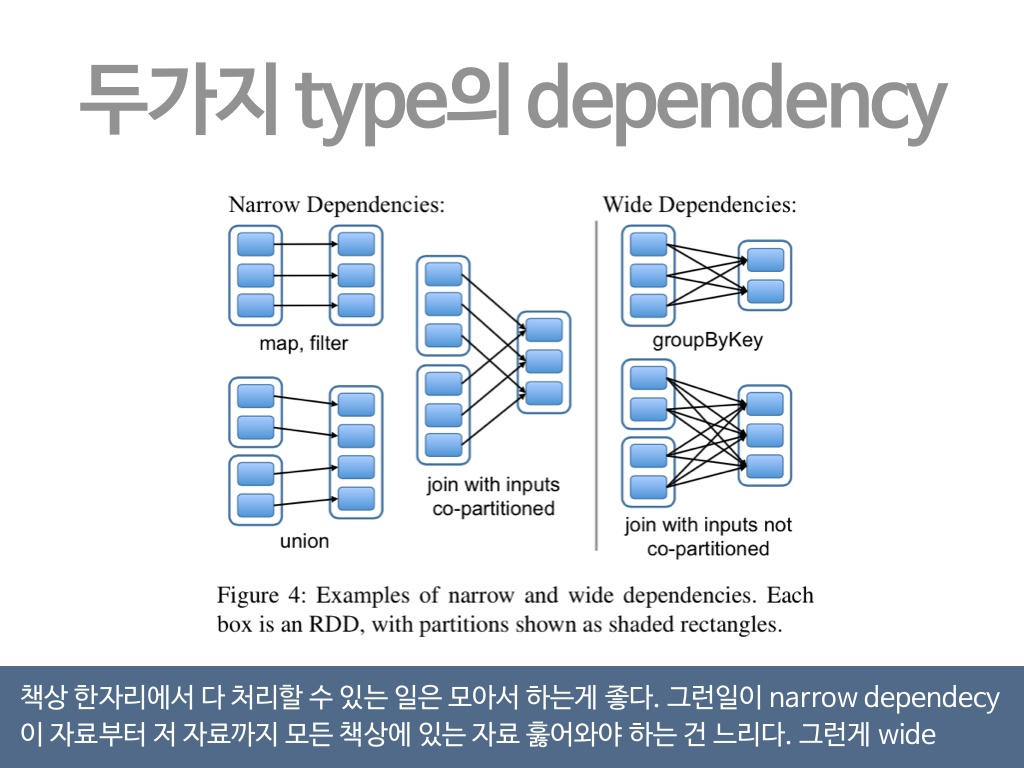
* Narrow Dependency
    * 작업이 한 노드에서만 실행 = 네트워크 타지 않음 = 빠름
    * 파티션이 fault되더라도 노드에서 복원 가능
* Wide Dependency
    * 셔플이 일어남 = 네트워크 타야함
    * fault 일어나면 안됨 = check point 설정 = 계산 비용 높음

source: https://www.slideshare.net/yongho/rdd-paper-review
## 클러스터 구조
![클러스터 구조](spark_cluster_arch.png)
* 프로세스 
    1. SparkContext가 SparkClusterManager에 접속한다. 이 클러스터 메니져는 스팍 자체의 클러스터 메니져가 될 수 도 있고 Mesos,YARN 등이 될 수 있다. 이 클러스터 메니저를 통해서 가용한 Executor 들을 할당 받는다
    2. Executor를 할당 받으면, 각각의 Executor들에게 수행할 코드를 보낸다.
    3. 다음으로 각 Excutor 안에서 Task에서 로직을 수행한다.
* 용어 정리
    * Executor : Process
    * Task : A Unit of work that will be sent to one executor
    * Worker Node : 하드웨어 서버

source: [조대협의 블로그](http://bcho.tistory.com/1025?category=563141)

# Linking with Spark
* python 2.7이상이나 python 3.4이상을 지원한다.
* Cpython을 쓰고 있다면 Numpy같은 C 라이브러리 사용 가능
* pipi 사용 가능

파이썬으로 작성된 스파크 어플리케이션 `bin/spark-submit`을 이용하거나 `setup.py`에 아래애 코드를 추가해주면 된다.

```python
install_requires=[
    'pyspark=={site.SPARK_VERSION}'
]
```

`bin/spark-submit`를 이용하면 클러스터에 앱을 올릴 수 있다.

아래는 파이썬 버전에 따라 pyspark shell을 실행하는 방법이다.
```bash
$ PYSPARK_PYTHON=python3.4 bin/pyspark
$ PYSPARK_PYTHON=/opt/pypy-2.5/bin/pypy \ 
    bin/spark-submit examples/src/main/python/pi.py
```

아래의 모듈을 추가하면 클러스터를 시작할 수 있다.
```python
from pyspark import SparkContext, SparkConf
```

# Initializing Spark 
***
verion 2.3.1 기준

반드시 `SparkContext`와 `SparkConf`를 만들어야 한다. `master`는 Spark나 Mesos, YARN cluster URL 또는 local이 될 수 있다. 실제로 이를 직접 하드코드할 일은 없으며 `spark-submit`를 이용하게 될 것이다.

In [ ]:
from pyspark import SparkContext, SparkConf
conf= SparkConf().setAppName("First").setMaster("local[4]")
sc = SparkContext(conf=conf)

conf -> 설정파일 생성

sc = SparkContext 생성 with conf

## Using the Shell

실행법
```shell
./bin/pyspark --master local[4]
./bin/pyspark --master local[4] --py-files code.py
```
기본 문법
```shell
./bin/spark-submit 
  --class <main-class> 
  --master <master-url> 
  --deploy-mode <deploy-mode> 
  --conf <key>=<value> 
  ... # other options
  <application-jar> 
  [application-arguments]
  ```
  

옵션
* --class: The entry point for your application (e.g. org.apache.spark.examples.SparkPi)
* --master: The master URL for the cluster (e.g. spark://23.195.26.187:7077)
    * local : 하나의 work thread에서만 스파크 실행
    * local[K]: K개의 work thread에서 스파크 실행
    * local[K, F]: K개의 work thread에서 F개의 maxFailures
    * local[*]: 최대한 많은 work thread
    * spark://HOST:PORT : Spark standalone cluster
    * spark://HOST1:PORT1,HOST2:PORT2 : spark standalone cluster +  zookeeper
    * ...
* --deploy-mode: Whether to deploy your driver on the worker nodes (cluster) or locally as an external client (client) (default: client) †
* --conf: Arbitrary Spark configuration property in key=value format. For values that contain spaces wrap “key=value” in quotes (as shown).
* application-jar: Path to a bundled jar including your application and all dependencies. The URL must be globally visible inside of your cluster, for instance, an hdfs:// path or a file:// path that is present on all nodes.
* application-arguments: Arguments passed to the main method of your main class, if any

```shell
PYSPARK_DRIVER_PYTHON=ipython ./bin/pyspark
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./bin/pyspark
```
이런 식으로도 사용 가능하다

# RDD (Resilient Distribued Dataset)
-----
a fault-tolerant collection of element that can be operated on in parallel.

RDD를 생성하는 방법은 크게 2 가지
* driver 프로그램에 존재하는 collection을 paralleizing
* 외부 저장소(e.g. shared filesystem, HDFS, HBase ...)의 데이터셋을 참조

## Parallelized Collections
직접 iterable 객체 넣기

In [ ]:
data = [1, 2, 3, 4, 5]
distData = sc.parallelize(data)
distData.reduce(lambda a, b: a + b)

스파크는 클러스터의 각 파티션마다 하나의 태스크만 실행

클러스터의 각 CPU마다 2-4개 정도의 파티션으로 나누는 경우가 많음

일반적으로 스파크가 알아서 파티션 수를 설정하려고 하지만 직접 설정도 가능함

In [ ]:
sc.parallelize(data, 10) # 10개의 파티션으로 나누어 저장

## External Dataset
SparkContext.textFile 메소드 이용

In [ ]:
distFile = sc.textFile("[path/ URL]")

### 텍스트 파일
* 경로가 로컬 파일시스템일 경우 worker node도 같은 경로에서 접근 가능해야 하다.따라서  읽을 파일을 모든 워커노드에 저장하거나 네트워크 마운트된 파일 시스템을 이용해야 함
* 모든 파일 기반 input 메소드는 디렉토리, 압축 파일, 와일드 카드 모두 지원, 예를 들면 `textFile("/my/directory")`, `textFile("/my/directory/*.txt")`, `textFile("/my/directory/*.gz")` 모두 가능
* textFile 메소드는 파티션 수를 정하는 2번째 파라미터를 받을 수 있음 (디폴트로 각 파일의 블록은 하나의 파티션을 생성하나 설정 가능)
* 한 줄이 하나의 Row 오브젝트

### 다른 포맷의 파일 (python)
*  SparkContext.wholeTextFiles : 한 디렉토리 내의 여러 파일 읽기, 반환은 filename:content 페어
* RDD.saveAsPickleFile/ SparkContext.pickleFile
*  SequenceFile and Hadoop Input/Output Formats

### Saving and Loading SequenceFiles

In [ ]:
import os
os.system("rm -rf ./testfile")
rdd = sc.parallelize(range(1, 4)).map(lambda x: (x, "a" * x))
rdd.saveAsSequenceFile("./testfile")
sorted(sc.sequenceFile("./testfile").collect())

# RDD Operations
***
2 종류의 연산이 존재
* Transformation: 이미 존재하는 데이터셋으로 부터 새로운 데이터 셋 생성 (e.g. map)
* Actions: 데이터셋에 대한 연산을 실행 후 Driver Program에 결과값 전달 (e.g. reduce)

모든 Transformation은 *lazy* --> Driver Program에 결과를 돌려줘야 할 때만 연산 수행

디폴트로 Transform된 RDD는 Action을 실행했을 때에만 다시 계산되나, persist(or cache) 메소드로 메모리에 상주시키는 것도 가능, 빠른 엑세스와 쿼리를 가능하게 함.

## Basics

In [ ]:
lines = sc.textFile("data.txt") # lines는 메모리에 로드되지 않음, 단순히 파일에 대한 포인터
lineLengths = lines.map(lambda s: len(s)) # Transformation: 바로 계산 안됨
totalLength = lineLengths.reduce(lambda a, b: a + b) # Action

# lineLength를 나중에 빠르게 다시 사용하기 위해 reduce하기 전에 persist 이용 
lineLengths.persist() 

## Passing Functions to Spark
* 모듈의 Top-level function

### Lambda Expression
한 줄 코드/ 짧은 코드에 유용

### 로컬 def
여러 줄 코드에 유용

In [ ]:
def myFunc(s):
    words = s.split(" ")
    return len(words)

rs = sc.textFile("data.txt").map(myFunc).collect()

### 클래스 인스턴스의 메소드
예시 1)
```python
class MyClass(object):
    def func(self, s):
        return s
    def doStuff(self, rdd):
        return rdd.map(self.func)
```
다음과 같은 경우 doStuff 내부의 map이 func을 참조해야 하므로 클래스 인스턴스 전체를 넘겨야 함

예시 2)
```python
class MyClass(object):
    def __init__(self):
        self.field = "Hello"
    def doStuff(self, rdd):
        return rdd.map(lambda s: self.field + s)
```
map이 self.field를 참조해야하므로 클래스 전체가 필요
```python
def doStuff(self, rdd):
    field = self.field
    return rdd.map(lambda s: field + s)
```
doStuff를 위와 같이 바꾸면 map이 클래스 전체를 참조할 필요가 없다

In [ ]:
## 첫번째 예시
class MyClass(object):
    def func(self, s):
        return s
    def doStuff(self, rdd):
        return rdd.map(self.func)

In [ ]:
cls = MyClass()

In [ ]:
sample = sc.textFile("data.txt")
cls.doStuff(sample).collect()

In [ ]:
## 첫번째 예시
class MyClass2(object):
    def __init__(self):
        self.field = "Hello"
    def doStuff(self, rdd):
        return rdd.map(lambda s: self.field + s)

In [ ]:
cls = MyClass2()
cls.doStuff(sample).collect()

## Closure의 이해
***
### Local vs cluster mode
* Spark는 RDD 연산을 task로 나누며 각 executor가 각각의 task를 실행함
* 실행하기 전에 Spark는 task의 closure를 먼저 연산함
* Clousre는 executor가 RDD에 대한 연산(e.g. 아래 예시의 foreach)을 수행하기 위해 가시적이어야 하는 변수와 메소드를 말함

In [ ]:
# 예시
data=range(10)
counter = 0
rdd = sc.parallelize(data)

# Wrong: Don't do this!!
def increment_counter(x):
    global counter
    counter += x
rdd.foreach(increment_counter)

print("Counter value: ", counter) # 업데이트 안됨

(위 코드조각 설명) <br>
각 executor에게 보내진 clousre 내부의 변수들은 복사됨 <br>
--> foreach함수가 참조하는 counter 변수는 함수 밖에 선언된 counter가 아닌 counter의 복사본(<-> serialized clousre의 counter변수) <br>
--> 업데이트가 안되는 것을 확인할 수 있음

Local 모드에서 `foreach`함수가 같은 가상 머신 위에서 실행된 경우 counter 값이 업데이트될 수도 있으나 일반적인 상황에서는 아니다.

위 같은 상황을 해결하기 위해서 `Accumulator`를 사용해야 한다. `Accumulator`는 workder node들이 흩어져서 함수를 실행하는 상황에서도 안전한 변수 업데이트가 가능하도록 한다.

### Printing elements of an RDD

In [ ]:
data = range(20)
rdd = sc.parallelize(data)
def println(x):
    print(x)
rdd.foreach(println)
rdd.map(println)

위 예시는 하나의 머신에서 구동할 경우 잘 작동할 것이다. 그러나 cluster모드에서는 각 함수에서 stdout으로의 출력이 각 머신에서 이루어지기 때문에 driver에서는 출력물을 확인할 수 없고 각 executor에서 확인 가능하다.

위와 같은 문제를 해결하기 위해서 *collect* 메소드를 사용한다.

In [ ]:
print(rdd.collect()) # 데이터가 많은 경우 메모리가 부족할 수 있음 
print(rdd.take(100) )# 100개의 데이터만 가져옴

## Working with K-V Pairs
RDD는 어떤 object도 가지고 있을 수 있는데 특별하게 Key-Value 타입의 object에 대해서 추가적인 연산을 지원한다.

Python에서는 이러한 연산은 built-in 타입인 튜플 (e.g. (1, 2) )을 가지고 한다. <br>
아래 예시 참고)

In [ ]:
lines = sc.textFile("NYTimes.txt")
pairs = lines.map(lambda s: (s, 1))
counts = pairs.reduceByKey(lambda a, b: a + b)
for i in counts.take(5):
    print(i)
sortedPair = pairs.sortByKey()
for i in sortedPair.take(5):
    print(i)


## Transformations
자주 쓰이는 메소드만 정리 <br>
자세한 API 문서는 [Python RDD API Doc](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)을 참고

|Transformation|Meaning|
|:------|:------|
|__map__(_func_)|Return a new distributed dataset formed by passing each element of the source through a function func.|
|__filter__(_func_)|Return a new dataset formed by selecting those elements of the source on which func returns true.|
|__flatMap__(_func_)|Similar to map, but each input item can be mapped to 0 or more output items (so func should return a Seq rather than a single item).|
|__mapPartitions__(_func_)|Similar to map, but runs separately on each partition (block) of the RDD, so func must be of type Iterator<T> => Iterator<U> when running on an RDD of type T.|
|__mapPartitionsWithIndex__(_func_)|Similar to mapPartitions, but also provides func with an integer value representing the index of the partition, so func must be of type (_Int, Iterator<T>_) => Iterator<U> when running on an RDD of type T.|
|__sample__(_withReplacement, fraction, seed_)|Sample a fraction fraction of the data, with or without replacement, using a given random number generator seed.|
|__union__(_otherDataset_)|Return a new dataset that contains the union of the elements in the source dataset and the argument.|
|__intersection__(_otherDataset_)|Return a new RDD that contains the intersection of elements in the source dataset and the argument.|
|__distinct__(_[numTasks]_)_)|Return a new dataset that contains the distinct elements of the source dataset.|
|__groupByKey__(_[numTasks]_)|When called on a dataset of (_K, V_) pairs, returns a dataset of (_K, Iterable<V>_) pairs. <br>Note: If you are grouping in order to perform an aggregation (_such as a sum or average_) over each key, using reduceByKey or aggregateByKey will yield much better performance.<br>Note: By default, the level of parallelism in the output depends on the number of partitions of the parent RDD. You can pass an optional numTasks argument to set a different number of tasks.|
|__reduceByKey__(_func, [numTasks]_)|When called on a dataset of (_K, V_) pairs, returns a dataset of (_K, V_) pairs where the values for each key are aggregated using the given reduce function func, which must be of type (_V,V_) => V. Like in groupByKey, the number of reduce tasks is configurable through an optional second argument.|
|__aggregateByKey__(_zeroValue_)(_seqOp, combOp, [numTasks]_)|When called on a dataset of (_K, V_) pairs, returns a dataset of (_K, U_) pairs where the values for each key are aggregated using the given combine functions and a neutral "zero" value. Allows an aggregated value type that is different than the input value type, while avoiding unnecessary allocations. Like in groupByKey, the number of reduce tasks is configurable through an optional second argument.|
|__sortByKey__(_[ascending], [numTasks]_)|When called on a dataset of (_K, V_) pairs where K implements Ordered, returns a dataset of (_K, V_) pairs sorted by keys in ascending or descending order, as specified in the boolean ascending argument.|
|__join__(_otherDataset, [numTasks]_)|When called on datasets of type (_K, V_) and (_K, W_), returns a dataset of (_K, (_V, W_)_) pairs with all pairs of elements for each key. Outer joins are supported through leftOuterJoin, rightOuterJoin, and fullOuterJoin.|
|__cogroup__(_otherDataset, [numTasks]_)|When called on datasets of type (_K, V_) and (_K, W_), returns a dataset of (_K, (_Iterable<V>, Iterable<W>_)_) tuples. This operation is also called groupWith.|
|__cartesian__(_otherDataset_)|When called on datasets of types T and U, returns a dataset of (_T, U_) pairs (_all pairs of elements_).|
|__pipe__(_command, [envVars]_)|Pipe each partition of the RDD through a shell command, e.g. a Perl or bash script. RDD elements are written to the process's stdin and lines output to its stdout are returned as an RDD of strings.|
|__coalesce__(_numPartitions_)|Decrease the number of partitions in the RDD to numPartitions. Useful for running operations more efficiently after filtering down a large dataset.|
|__repartition__(_numPartitions_)|Reshuffle the data in the RDD randomly to create either more or fewer partitions and balance it across them. This always shuffles all data over the network.|
|__repartitionAndSortWithinPartitions__(_partitioner_)|Repartition the RDD according to the given partitioner and, within each resulting partition, sort records by their keys. This is more efficient than calling repartition and then sorting within each partition because it can push the sorting down into the shuffle machinery.


## Actions
자주 쓰이는 메소드만 정리 <br>
자세한 API 문서는 [Python RDD API Doc](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)을 참고

|Action|Meaning||
|:------|:------||
|__reduce__(_func_)|Aggregate the elements of the dataset using a function func (which takes two arguments and returns one). The function should be commutative and associative so that it can be computed correctly in parallel.|
|__collect__()|Return all the elements of the dataset as an array at the driver program. This is usually useful after a filter or other operation that returns a sufficiently small subset of the data.|
|__count__()|Return the number of elements in the dataset.|
|__first__()|Return the first element of the dataset (similar to take(1)).|
|__take__(_n_)|Return an array with the first n elements of the dataset.|
|__takeSample__(_withReplacement, num, [seed]_)|Return an array with a random sample of num elements of the dataset, with or without replacement, optionally pre-specifying a random number generator seed.|
|__takeOrdered__(_n, [ordering]_)|Return the first n elements of the RDD using either their natural order or a custom comparator.|
|__saveAsTextFile__(_path_)|Write the elements of the dataset as a text file (or set of text files) in a given directory in the local filesystem, HDFS or any other Hadoop-supported file system. Spark will call toString on each element to convert it to a line of text in the file.|
|__saveAsSequenceFile__(_path_)<br>(Java and Scala)|Write the elements of the dataset as a Hadoop SequenceFile in a given path in the local filesystem, HDFS or any other Hadoop-supported file system. This is available on RDDs of key-value pairs that implement Hadoop's Writable interface. In Scala, it is also available on types that are implicitly convertible to Writable (Spark includes conversions for basic types like Int, Double, String, etc).|
|__saveAsObjectFile__(_path_)<br>(Java and Scala)|Write the elements of the dataset in a simple format using Java serialization, which can then be loaded using SparkContext.objectFile().|
|__countByKey__()|Only available on RDDs of type (K, V). Returns a hashmap of (K, Int) pairs with the count of each key.|
|__foreach__(_func_)|Run a function func on each element of the dataset. This is usually done for side effects such as updating an Accumulator or interacting with external storage systems.<br>Note: modifying variables other than Accumulators outside of the foreach() may result in undefined behavior. See Understanding closures for more details. |

Async 버전의 메소드도 존재함: _foreach_ -> _foreachAsync_ (_FutureAction_을 리턴)

## Shuffle Operations
data를 재배치(re-distribution)
### Background
_reduceByKey_가 내부적으로 어떻게 실행되는지 확인해본다. _reduceByKey_은 모든 value를 하나의 key로 합쳐 하나의 튜플로 만든 새로운 RDD를 생성한다. 여기서의 문제는 같은 키를 공유하는 value가 하나의 파이션 또는 머신에 있지 않을 수도 있지만 계산하기 위해서는 같은 곳에 위치해야 한다는 점이다.

Spark는 한 파티션에서 하나의 task만을 수행하기 때문에 all-to-all로 연산을 수행해야 한다. 따라서 _reduceByKey_를 실행하면 모든 파티션에서 각 key를 찾는 과정이 필요하다. 이 과정이 _Shuffle_이다.

_Shuffle_이 발생하는 메소드로는 다음과 같은 메소드들이다.
* repartition 관련 함수(e.g. repartition/ coalesce)
* ByKey 관련 함수 (counting 제외) (e.g.  groupByKey/ reduceByKey)
* join 관련 함수 (e.g. cogroup/ join)

### 성능 이슈
disk I/O와 data serializatino, network I/O를 수반하므로 매우 비싼 연산
* 내부적으로 각각의 map task에 대한 결과는 메모리에 저장된다. 이 결과는 타겟 파티션을 기준으로 정렬되어 하나의 파일로 저장된다. Reduce과정에서 정렬된 파일을 읽어온다.
* 특정 Shuffle 연산은 인메모리 자료구조가 필요하여 힙 메모리가 부족할 수 있다. 특별히 _reduceByKey_과 _aggregateByKey_은 map 과정에서, ByKey 관련 연산은 reduce과정에서 이러한 자료 구조들이 필요하다. 메모리가 부족하게 되면 필요 없는 부분을 디스크에 쓰게 되므로 disk I/O와 관련한 오버헤드가 발생한다.
* 재연산 과정에서 shuffle 파일이 발생하지 않도록 많은 일시적인 파일들을 생성하며 이 파일들을 오랜시간 사용되지 않으면 GC가 처리한다. 오랜 시간동안 실행되어야 하는 작업일 경우 디스크 공간을 많이 차지할 수 있다. 처음 spark context를 설정할 때 _spark.local.dir_ 의 크기를 결정할 수 있다. [Spark Configuration Guide](https://spark.apache.org/docs/latest/configuration.html) 참고

## RDD Persistence
데이터셋을 메모리에 immutable한 상태로 저장하는 것(Caching과 비슷)
RDD를 persist하면 각 노드는 계산돼야 하는 파티션들을 메모리에 저장하고 해당 데이터셋에 대한 다른 연산을 수행할 때 재사용한다.

_persist()_ 또는 _cache()_를 통해 특정 RDD를 Caching할 수 있다.

캐싱 레벨 설정 가능
### Which Storage Level to Choose?
[문서](https://spark.apache.org/docs/latest/rdd-programming-guide.html#which-storage-level-to-choose)를 참고
### Removing Data
스파크는 각 노드의 캐시 사용률을 모니터링 하여 LRU방식으로 캐싱을 drop하기도 한다. 직접 캐싱된 RDD를 drop하려면 `RDD.unpersist()`메소드를 사용하면 된다.

# Shared Variables
* broadcast variable
* `acculators`
두 가지 방식으로 각 노드간 변수를 공유할 수 있다.
## Brodcast Variables
read-only 변수를 각 노드에 저장한다. 매우 큰 데이터셋을 공유할 때 사용될 수 있다. 전송 비용을 줄이기 위해 효율적인 알고리즘을 사용한다.

스파크의 action들은 _suffle_ 연산으로 나누어진 몇 개의 단계로 이루어진다. 스파크는 자동적으로 각 task의 각 단계에 필요한 공통의 데이터를 각 노드에 전달한다. 전달된 데이터는 serialize되어 캐시되고 각 단계에서 해당 데이터를 사용할 때 deserialize된다.
> Explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

`SparkContext.broadcast(v)` 형태로 broadcast variable을 만들 수 있다. 해당 값은 v가 아닌 `value`메소드를 통해서만 접근 가능하다.

In [ ]:
broadcastVar = sc.broadcast([1, 2, 3])

In [ ]:
broadcastVar.value

한 번 생성된 broadcast variable을 변경 불가능하다.

## Accumulators

In [32]:
## 기본적인 numeric accumulator
# 초기화
accum = sc.accumulator(0)
accum

Accumulator<id=1, value=0>

In [33]:
# foreach로 x값 다 더하기
sc.parallelize([1, 2, 3, 4]).foreach(lambda x: accum.add(x))
accum.value

10

In [ ]:
## User Defined Type accumulator
# class definition
class VectorAccumulatorParam(AccumulatorParam):
    def zero(self, initialValue):
        return Vector.zeros(initialValue.size)

    def addInPlace(self, v1, v2):
        v1 += v2
        return v1

# Then, create an Accumulator of this type:
vecAccum = sc.accumulator(Vector(...), VectorAccumulatorParam())

# Deploying to a cluster
[application submission guide](https://spark.apache.org/docs/latest/submitting-applications.html)를 참고

파이썬은 `.py` 또는 `.zip` 파일을 `./bin/spark-submit`를 통해 클러스터 매니저에게 보내는 것이다.

# Unit Testing
어떤 유닛 테스팅 프레임이든지 잘 작동하나 마지막에 SparkContext.stop()을 호출해서 멈춰야 한다. 2개의 SparkContext를 지원하지 않는다.